# Erstellung der Benchmark Modelle
1. [Dickey-Fuller-Test](#1)
1. [Time Series Split](#2)
1. [AutoARIMA](#3)
1. [Exponential Smoothing](#4)
1. [Facebook Prophet](#5)
1. [Grafische Darstellung](#6)

In [2]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for nfoursid>=1.0.0 from https://files.pythonhosted.org/packages/0a/92/dda081df8d207b72e419ef5dbd6a861041ceabdc609557249f334555a619/nfoursid-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/95/3c/c58057dde22b0

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from darts import TimeSeries
from darts.metrics import mae, rmse

plt.style.use('ggplot')

RED = '#FF3247'
BLUE = '#0f6df0'
ONE_DAY = 24
ONE_WEEK = ONE_DAY * 7

print("Setup complete")

Setup complete


In [4]:
df = pd.read_csv("../input/2024-02-18/exploratory_analysis.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)

df_save = df.copy()
df = df[['use']]

df.head()

,use
timestamp,
2018-01-01 00:00:00,0.58575
2018-01-01 01:00:00,0.43750
2018-01-01 02:00:00,0.47875
2018-01-01 03:00:00,0.52275
2018-01-01 04:00:00,0.41825


<a id="1"></a>
## 1. Dickey-Fuller-Test
* https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [5]:
adf_result = adfuller(df)

test_statistic = adf_result[0]
crit_values = adf_result[4]
max_crit_value = max(crit_values.values())

print("Teststatistik: ", test_statistic)
print("Kritische Werte: ", crit_values)
print()

if test_statistic > max_crit_value: # Trend
    print(f"Die Teststatisik ist größer als die kritischen Werte bei 10%: {round(test_statistic, 2)} > {round(max_crit_value, 2)}")
    print("Die Nullhypothese kann nicht abgelehnt werden")
    print("Die Zeitreihe ist nicht stationär")
else: # Kein Trend
    print("""Die Teststatistik ist kleiner als die kritischen Werte bei 1%, """
          """daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt""")

Teststatistik:  -5.861203580989642
Kritische Werte:  {'1%': -3.431099710594876, '5%': -2.8618713221545193, '10%': -2.5669463578164384}

Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt


<a id="2"></a>
## 2. Time Series Split
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

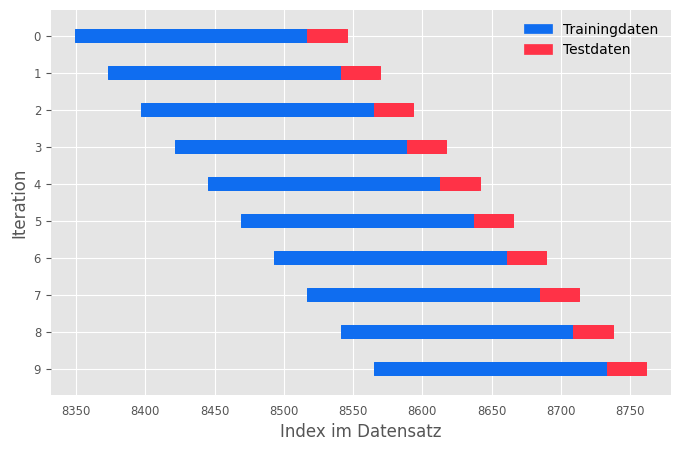

In [6]:
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import TimeSeriesSplit

cmap_cv = LinearSegmentedColormap.from_list(name='br', colors=[BLUE, RED])


def plot_cv_indices(df, cv):
    """
    Erstellt eine Visualisierung für die Aufteilung in Trainings- und Testdaten durch den Time Series Split.
    :param df: Ein Dataframe, der eine Spalte 'use' mit realen Messwerten enthält.
    :param cv: Das TimeSeriesSplit-Objekt, das Informationen zu den folds enthält.
    """
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(df.use)):
        indices = np.array([np.nan] * len(df))
        indices[train_idx] = 0
        indices[test_idx] = 1
        ax.scatter(range(len(indices)), [fold + 0.5] * len(indices), c=indices, cmap=cmap_cv, marker='_', lw=10)
    
    n_splits = cv.get_n_splits()
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        ylim=[n_splits + 0.2, -0.2]
    )
    
    ax.set_xlabel("Index im Datensatz", fontweight='normal')
    ax.set_ylabel("Iteration", fontweight='normal')
    
    ax.legend(
        [Patch(color=BLUE), Patch(color=RED)],
        ['Trainingdaten', 'Testdaten'],
        loc='upper right'
    )
    
    fig.savefig('tss_vis.svg', bbox_inches='tight')
    plt.show()


tscv = TimeSeriesSplit(n_splits=10, max_train_size=ONE_WEEK, test_size=ONE_DAY)
plot_cv_indices(df, tscv)

In [7]:
def predict_daily(df, model):
    """
    Erstellt eine Vorhersage für die bereitgestellten Daten mit dem angegebenen Modell.
    :param df: Ein Dataframe, der einen Zeitstempel und eine Spalte 'use' mit realen Messwerten enthält.
    :param model: Ein angepasstes Modell aus der darts Bibliothek.
    :return: Eine Liste aller Vorhersagen für das entsprechende Modell.
    """
    historical_forecast = model.historical_forecasts(
        series=series,
        train_length=ONE_WEEK,
        forecast_horizon=ONE_DAY,
        last_points_only=False,
        stride=ONE_DAY,
        verbose=True
    )
    
    comb_df = pd.DataFrame()
    
    for fold in historical_forecast:
        preds = fold.pd_dataframe()
        comb_df = pd.concat([comb_df, preds])
    
    return comb_df


def eval_model(df, model_str):
    """
    Berechnet MAE und RMSE zwischen den tatsächlichen und vorhergesagten Werten und gibt diese in der Konsole aus.
    :param df: Ein Dataframe, der eine Spalte 'use' mit tatsächlichen Messwerten und
               eine Spalte mit vorhergesagten Werten für das entsprechende Modell enthält.
    :param model_str: Der Name der Spalte für die vorhergesagten Werte.
    """
    # In darts TimeSeries Objekte konvertieren
    actual = TimeSeries.from_values(df['use'])
    predicted = TimeSeries.from_values(df[model_str])
    
    avg_mae = mae(actual, predicted)
    avg_rmse = rmse(actual, predicted)
    
    print(f"MAE: {round(avg_mae, 2)}, RMSE: {round(avg_rmse, 2)}")

<a id="3"></a>
## 3. AutoARIMA
### Setting m: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
1. Saisonalitätsannahme: Der Wert m gibt die Länge der saisonalen Periode an. Bei m=24 geht das Modell davon aus, dass sich das Muster Ihrer Zeitreihe alle 24 Stunden wiederholt. Dies ist typisch für stündliche Daten, bei denen Sie tägliche Muster erwarten, wie z.B. höhere Aktivität während des Tages und niedrigere Aktivität in der Nacht.
2. Saisonale Differenzierung: Im Kontext von ARIMA-Modellen (und deren Erweiterungen wie SARIMA oder AutoARIMA) bezieht sich die saisonale Differenzierung auf die Anzahl der Differenzierungen, die erforderlich sind, um die saisonale Komponente der Zeitreihe stationär zu machen. Bei m=24 wird AutoARIMA versuchen, saisonale Effekte zu erkennen und zu modellieren, die sich im 24-Stunden-Rhythmus wiederholen.
3. Anwendungsbereiche: Ein solches Modell wäre beispielsweise sinnvoll bei der Analyse von Verkehrsdaten, Energieverbrauch, Webseitenaufrufen oder anderen stündlichen Messungen, bei denen tägliche Schwankungen eine Rolle spielen.
4. Modellierungskomplexität: Die Einbeziehung einer täglichen Saisonalität (m=24) in stündlichen Daten kann die Komplexität des Modells erhöhen. Es ist wichtig, die Modellpassung und -vorhersagen sorgfältig zu überprüfen, um sicherzustellen, dass das Modell die saisonalen Muster angemessen erfasst und nicht über- oder unterangepasst ist.

In [8]:
# In darts TimeSeries Objekt konvertieren
series = TimeSeries.from_series(df)

In [9]:
from darts.models import AutoARIMA

auto_arima_model = AutoARIMA(stationary=True, trend=None, seasonal=True)

arima_str = "arima_preds"
df_save[arima_str] = predict_daily(df, auto_arima_model)
eval_model(df_save, arima_str)

  0%|          | 0/358 [00:00<?, ?it/s]

MAE: 0.78, RMSE: 1.11


In [10]:
auto_arima_model_m = AutoARIMA(stationary=True, trend=None, seasonal=True, m=24)

arima_str_m = "arima_preds_m"
df_save[arima_str_m] = predict_daily(df, auto_arima_model_m)
eval_model(df_save, arima_str_m)

  0%|          | 0/358 [00:00<?, ?it/s]

MAE: 0.74, RMSE: 1.08


<a id="4"></a>
## 4. Exponential Smoothing

In [11]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing(trend=None, seasonal_periods=24)

es_str = "es_preds"
df_save[es_str] = predict_daily(df, es_model)
eval_model(df_save, es_str)

  0%|          | 0/358 [00:00<?, ?it/s]

MAE: 0.92, RMSE: 1.33


<a id="5"></a>
## 5. Facebook Prophet

In [12]:
from darts.models import Prophet

# Modell ohne Parameter ist schon sehr gut, Saisonalitäten bringen kaum einen Vorteil

# Für das Outcome ist die fourier_order nicht wirklich relevant.
# Getestet mit zufälligen werten zwischen 1 und 100 und nur minimale Abweichungen im 0,1% Bereich

prophet_model = Prophet(
    add_seasonalities=[ # weekly automatisch generiert
        {
            'name': "hourly",
            'seasonal_periods': ONE_DAY,
            'fourier_order': 5
        },
        {
            'name': "monthly",
            'seasonal_periods': 12,
            'fourier_order': 5
        }
    ],
    # country_holidays='TX', --> 'Holidays in TX are not currently supported!' --> Ergebnis mit US schlechter als manuell generiert
    suppress_stdout_stderror=True
)

prophet_str = "prophet_preds"
df_save[prophet_str] = predict_daily(df, prophet_model)
eval_model(df_save, prophet_str)

  0%|          | 0/358 [00:00<?, ?it/s]

15:03:53 - cmdstanpy - INFO - Chain [1] start processing
15:03:53 - cmdstanpy - INFO - Chain [1] done processing
15:03:54 - cmdstanpy - INFO - Chain [1] start processing
15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:54 - cmdstanpy - INFO - Chain [1] start processing
15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] start processing
15:03:56 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] start processing
15:03:56 - cmdstanpy - INFO - Chain [1] done processing
15:03:57 - cmdstanpy - INFO - Chain [1] start processing
15:03:57 - cmdstanpy - INFO - Chain [1] done processing
15:03:57 - cmdstanpy - INFO - Chain [1] start processing
15:03:57 - cmdstanpy - INFO - Chain [1]

MAE: 0.71, RMSE: 1.04


<a id="6"></a>
## 6. Grafische Darstellung

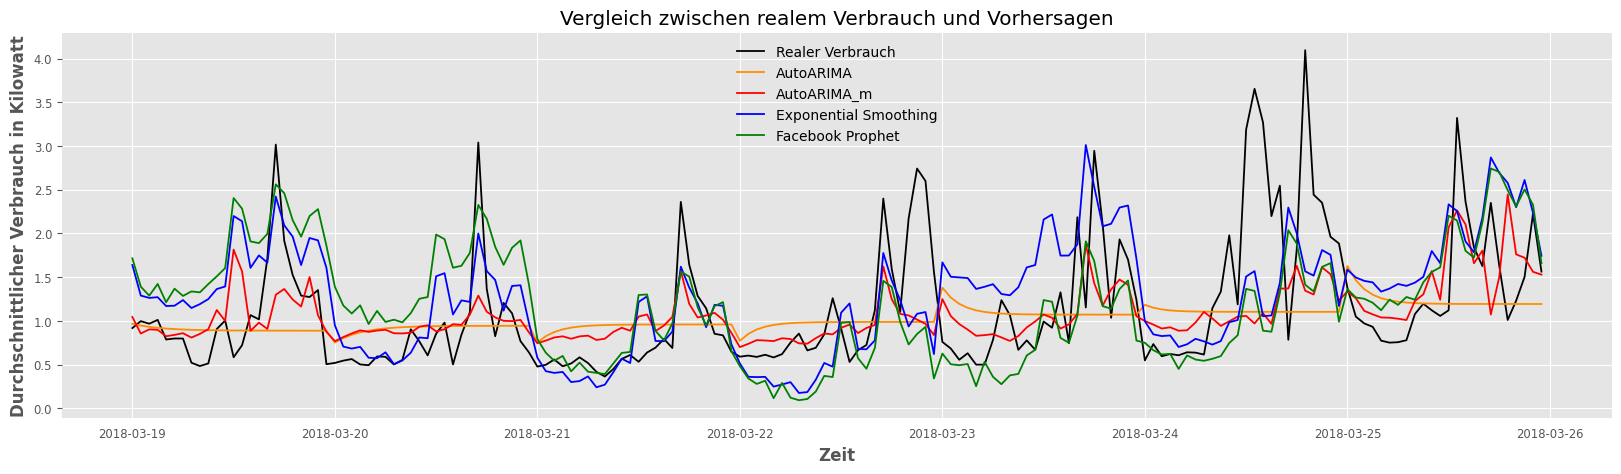

In [14]:
offset = 11
df_plot = df_save[ONE_WEEK*offset:ONE_WEEK*(offset+1)]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.use, color='black', label='Realer Verbrauch')
plt.plot(df_plot.index, df_plot.arima_preds, color='darkorange', label='AutoARIMA')
plt.plot(df_plot.index, df_plot.arima_preds_m, color='red', label='AutoARIMA_m')
plt.plot(df_plot.index, df_plot.es_preds, color='blue', label='Exponential Smoothing')
plt.plot(df_plot.index, df_plot.prophet_preds, color='green', label='Facebook Prophet')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch in Kilowatt')
plt.legend()
plt.show()

In [18]:
# Als csv-Datei speichern
df_save.to_csv('benchmark_models.csv')